In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
!pip install unidecode

In [115]:
# Instala a biblioteca
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import WhitespaceTokenizer
import seaborn as sns
from string import punctuation
import unidecode
from nltk.corpus import stopwords
from nltk import ngrams

# Baixa recursos necessários do NLTK
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [116]:
# Carrega o dataset
sentimentos = pd.read_csv("/content/Train3Classes.csv", encoding="utf-8", sep=';', on_bad_lines='skip')
print(sentimentos.head())

                                          tweet_text  \
0  @Laranjito76 A pessoa certa para isso seria o ...   
1  @behin_d_curtain Para mim, é precisamente o co...   
2  Vou fazer um video hoje... estou pensando em f...   
3  aaaaaaaa amei tanto essas polaroids, nem sei e...   
4  Valoriza o coração do menininho que vc tem. El...   

                       tweet_date  sentiment query_used  
0  Fri Oct 12 16:29:25 +0000 2018          1         :)  
1  Fri Oct 12 16:29:04 +0000 2018          1         :)  
2  Fri Oct 12 16:28:56 +0000 2018          1         :)  
3  Fri Oct 12 16:28:49 +0000 2018          1         :)  
4  Fri Oct 12 16:28:49 +0000 2018          1         :)  


In [117]:
# Renomeia colunas para nomes mais apropriados
sentimentos.rename(columns={'query_used': 'emoticon'}, inplace=True)
sentimentos.rename(columns={'sentiment': "classificacao"}, inplace=True)

In [118]:
# Divide o dataset em conjunto de treino e teste
treino, teste, classe_treino, classe_teste = train_test_split(sentimentos['tweet_text'], sentimentos['emoticon'], random_state=60)

In [119]:
# Remove linhas com valores nulos
sentimentos = sentimentos.dropna(how='all')
classe_teste

,emoticon
44887,:(
63574,:(
50100,:(
63010,:(
21739,:)
...,...
2243,:)
13425,:)
61233,:(
47647,:(


In [120]:
from itertools import count
# Cria um exemplo de texto
texto = ["a empresa tem propagando boas", "a empresa tem propagandas ruins"]
# Vetoriza o texto usando CountVectorizer
vetorizar = CountVectorizer()
bag_of_words = vetorizar.fit_transform(texto)

In [121]:
# Converte a matriz esparsa para um DataFrame
matriz_esparsa = pd.DataFrame(bag_of_words.toarray(), columns=vetorizar.get_feature_names_out())
matriz_esparsa
print(bag_of_words.shape)

(2, 6)


In [122]:
# Função para classificar texto usando Regressão Logística.
def classificar_texto(texto, coluna_texto, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase=False, max_features=50)
    bag_of_words = vetorizar.fit_transform(texto[coluna_texto])

    treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                                  texto[coluna_classificacao],
                                                                  random_state=60)
    regressao_logistica = LogisticRegression()
    regressao_logistica.fit(treino, classe_treino)
    acuracia = regressao_logistica.score(teste, classe_teste)
    return acuracia

%matplotlib inline

In [123]:
# Gera e exibe a nuvem de palavras
todas_palavras = ' '.join([texto for texto in sentimentos.tweet_text])

nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras)


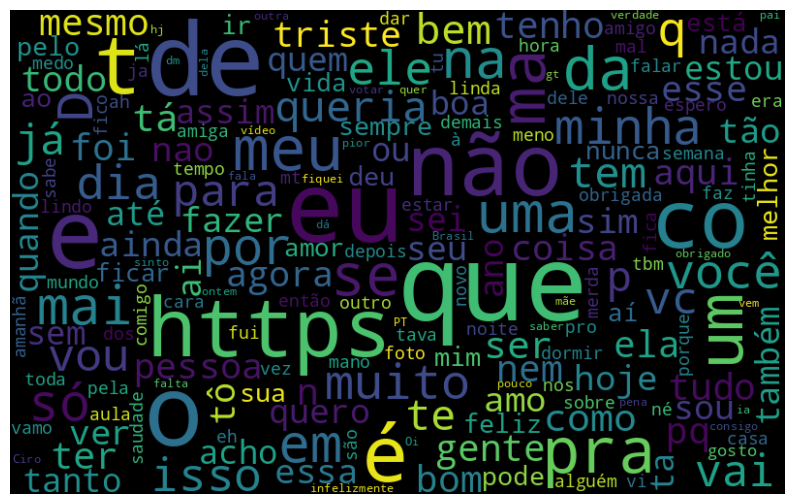

5490240

In [124]:
plt.figure(figsize=(10,7))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis("off")
plt.show()

len(todas_palavras)

In [125]:
#Função para gerar a nuvem de palavras para textos negativos.
def nuvem_palavras_neg(texto, coluna_texto):
    texto_negativo = texto.query("emoticon == ':('")
    todas_palavras = ' '.join([texto for texto in texto_negativo[coluna_texto]])

    nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras)

    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis("off")
    plt.show()



In [126]:
# Função para gerar a nuvem de palavras para textos positivos.
def nuvem_palavras_pos(texto, coluna_texto):
    texto_positiva = texto.query("emoticon == ':)'")
    todas_palavras = ' '.join([texto for texto in texto_positiva[coluna_texto]])

    nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras)

    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis("off")
    plt.show()

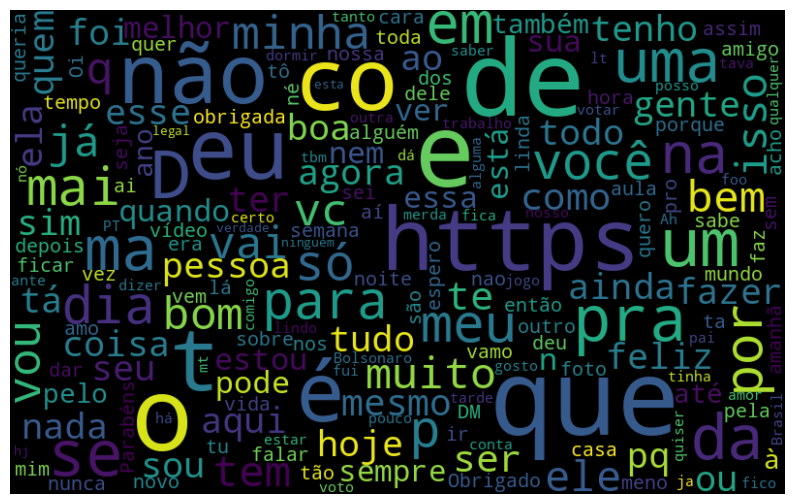

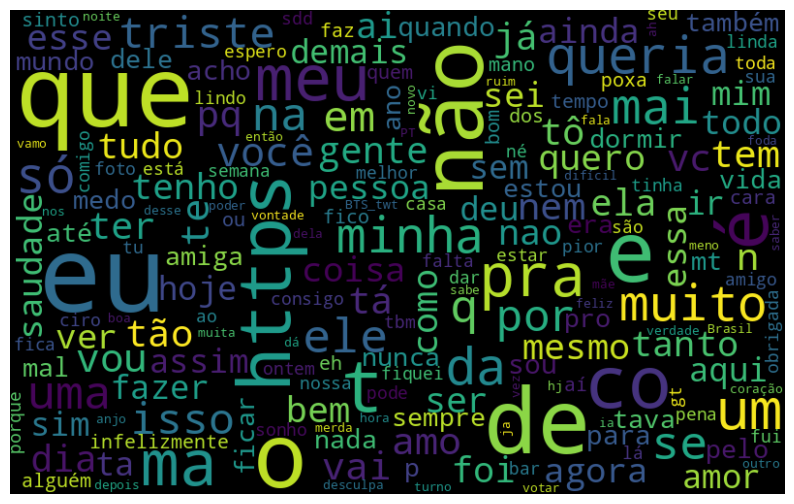

In [127]:
nuvem_palavras_pos(sentimentos, "tweet_text")
nuvem_palavras_neg(sentimentos, "tweet_text")

In [128]:
#  Função para gerar um gráfico de Pareto das palavras mais frequentes.
todas_palavras = ' '.join(sentimentos['tweet_text'].dropna())
token_espaco = WhitespaceTokenizer()
token_frase = token_espaco.tokenize(todas_palavras)
frequencia = nltk.FreqDist(token_frase)
df_frequencia = pd.DataFrame({"palavras": list(frequencia.keys()), "frequencia": list(frequencia.values())})
top_10_palavras = df_frequencia.nlargest(columns="frequencia", n=10)

df_frequencia.nlargest(columns= "frequencia", n=10)

,palavras,frequencia
2589,:(,27294
11,:),22995
65,que,20906
62,de,19164
9,e,16679
59,eu,15305
19,a,15293
7,o,14895
94,não,11788
15,é,10053


In [129]:
def pareto(texto, coluna_texto, quantidade):
    todas_palavras = ' '.join(texto[coluna_texto])

    token_espaco = WhitespaceTokenizer()
    token_frase = token_espaco.tokenize(todas_palavras)

    frequencia = nltk.FreqDist(token_frase)

    df_frequencia = pd.DataFrame({"palavras": list(frequencia.keys()), "frequencia": list(frequencia.values())})

    df_frequencia = df_frequencia.nlargest(columns="frequencia", n=quantidade)

    plt.figure(figsize=(12,8))
    ax = sns.barplot(data=df_frequencia, x="palavras", y="frequencia", color='gray')
    ax.set(ylabel="Contagem")
    plt.xticks(rotation=45)
    plt.show()

In [130]:
# Lista de stopwords em portuguê
pavavras_irrelevantes =  nltk.corpus.stopwords.words("portuguese")
print(pavavras_irrelevantes)
# Processa o texto removendo stopwords
frases_processadas = list()
for opiniao in sentimentos['tweet_text']:
    nova_frase = list()
    palavras_texto = token_espaco.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra.lower() not in pavavras_irrelevantes:
            nova_frase.append(palavra)
    frases_processadas.append(' '.join(nova_frase))

sentimentos['tratamento_1'] = frases_processadas

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

In [131]:
# Classifica o texto com o tratamento 1
classificar_texto(sentimentos, "tratamento_1", "classificacao")

0.614867702645947

In [132]:
# Adiciona pontuação à lista de stopwords
pontuacao = list()
for ponto in punctuation:
    pontuacao.append(ponto)

pontuacao_spotwords = pontuacao + pavavras_irrelevantes
# Processa o texto removendo stopwords e pontuação
frase_processda = list()
for opiniao in sentimentos ["tratamento_1"]:
  nova_frase = list()
  palavras_texto = token_pontuacao.tokenize(opiniao)
  for palavra in palavras_texto:
    if palavra not in pontuacao_spotwords:
      nova_frase.append(palavra)
  frase_processda.append(' '.join(nova_frase))

sentimentos["tratamento_2"] = frase_processda

sentimentos.head()
sentimentos["tratamento_1"]
sentimentos["tratamento_2"]

,tratamento_2
0,Laranjito76 pessoa certa vale azevedo
1,behin_d_curtain mim precisamente contrário Vem...
2,Vou fazer video hoje pensando falar pouco sobr...
3,aaaaaaaa amei tanto polaroids sei expressar qu...
4,Valoriza coração menininho vc diferente faça s...
...,...
66662,EsterOliveiraBR poxa
66663,exausta conseguir dormir
66664,5h14m vem cá amor
66665,amo mozão grita comigo nenê


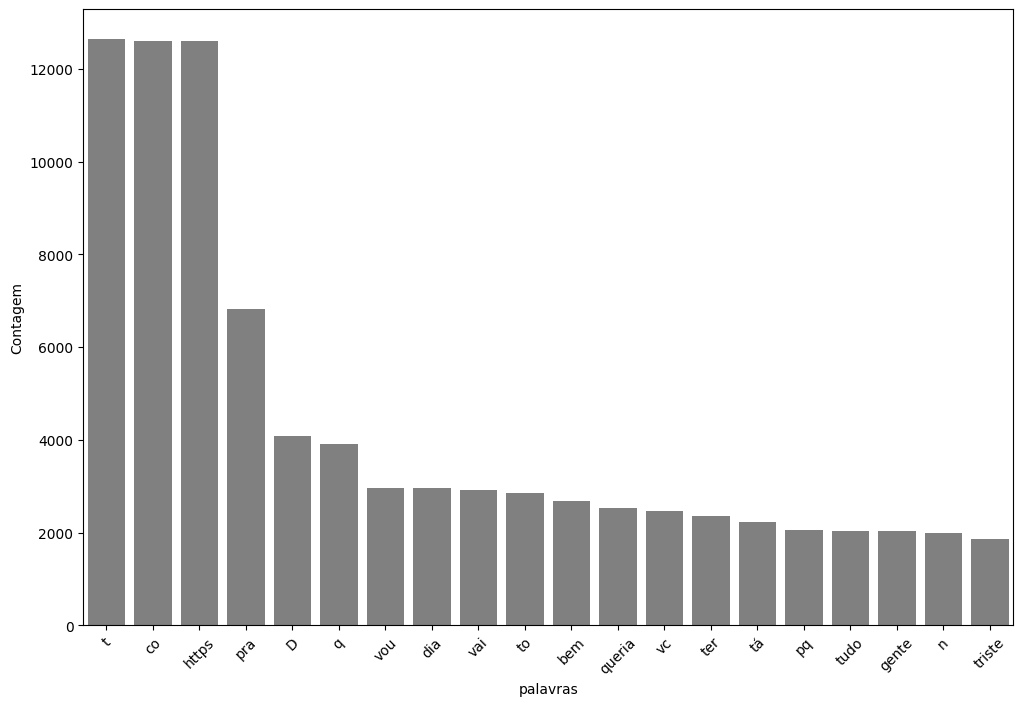

In [133]:
# Gera o gráfico de Pareto para o tratamento 2
pareto(sentimentos, "tratamento_2", 20)

In [134]:
# Remove acentos
acentos = "tão péssimo não é tão"
teste = unidecode.unidecode(acentos)
print(teste)

tao pessimo nao e tao


In [135]:
sem_acentos = [unidecode.unidecode(texto) for texto in sentimentos["tratamento_2"]]
sem_acentos[2]

'Vou fazer video hoje pensando falar pouco sobre novo meta CSGO sobre pagina https t co 5RjhKnj0oh Alguem sugestao Queria falar sobre algo cenario nacional D'

In [136]:
# Atualiza stopwords removendo acentos e outras palavras irrelevantes
stopwords_sem_acento = [unidecode.unidecode(texto) for texto in pontuacao_spotwords]
stopwords_sem_acento.extend(['vc', 'n', 'd', 'q', 'co', "...", "to", "t", "https", "HTTPS", "ta", "pra", "pq", "ai","Q", "T", "N", "--"])
stopwords_sem_acento_filtradas = [palavra for palavra in stopwords_sem_acento if len(palavra) > 1 and not all(char in punctuation for char in palavra)]
stopwords_sem_acento

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 'a',
 'a',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'as',
 'ate',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'e',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'eramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'esta',
 'estamos',
 'estao',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estavamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estiveramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivessemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'foramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fossemos',
 'fui',
 'ha',
 'haja

In [137]:
stopwords_sem_acento

sentimentos["tratamento_3"] = sem_acentos

# Processa o texto removendo stopwords e pontuação para tratamento 3
frase_processada = list()
for opiniao in sentimentos["tratamento_3"]:
    nova_frase = list()
    opiniao = opiniao.lower()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
# Verificar se a palavra não está na lista de stopwords e atende outros critérios, como comprimento mínimo
        if palavra.lower() not in stopwords_sem_acento and len(palavra) > 1:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))

In [138]:
sentimentos.head()

,tweet_text,tweet_date,classificacao,emoticon,tratamento_1,tratamento_2,tratamento_3
0,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:),@Laranjito76 pessoa certa vale azevedo :),Laranjito76 pessoa certa vale azevedo,Laranjito76 pessoa certa vale azevedo
1,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:),"@behin_d_curtain mim, precisamente contrário :...",behin_d_curtain mim precisamente contrário Vem...,behin_d_curtain mim precisamente contrario Vem...
2,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:),Vou fazer video hoje... pensando falar pouco s...,Vou fazer video hoje pensando falar pouco sobr...,Vou fazer video hoje pensando falar pouco sobr...
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:),"aaaaaaaa amei tanto polaroids, sei expressar q...",aaaaaaaa amei tanto polaroids sei expressar qu...,aaaaaaaa amei tanto polaroids sei expressar qu...
4,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:),Valoriza coração menininho vc tem. diferente. ...,Valoriza coração menininho vc diferente faça s...,Valoriza coracao menininho vc diferente faca s...


In [139]:
acuracia_tratamento3 = classificar_texto(sentimentos, "tratamento_3", "classificacao")
print(acuracia_tratamento3)

0.6164876702465951


In [140]:
sentimentos["tratamento_3"] = frase_processada

In [141]:
# Processa o texto removendo stopwords e pontuação filtradas para tratamento 4
frase_processada = list()
for opiniao in sentimentos["tratamento_3"]:
    nova_frase = list()
    opiniao = opiniao.lower()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra.lower() not in stopwords_sem_acento_filtradas:
          if palavra.lower() not in stopwords_sem_acento and len(palavra) > 1:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))

sentimentos["tratamento_4"] = frase_processada


In [142]:
acuracia_tratamento4 = classificar_texto(sentimentos,"tratamento_4", "classificacao")

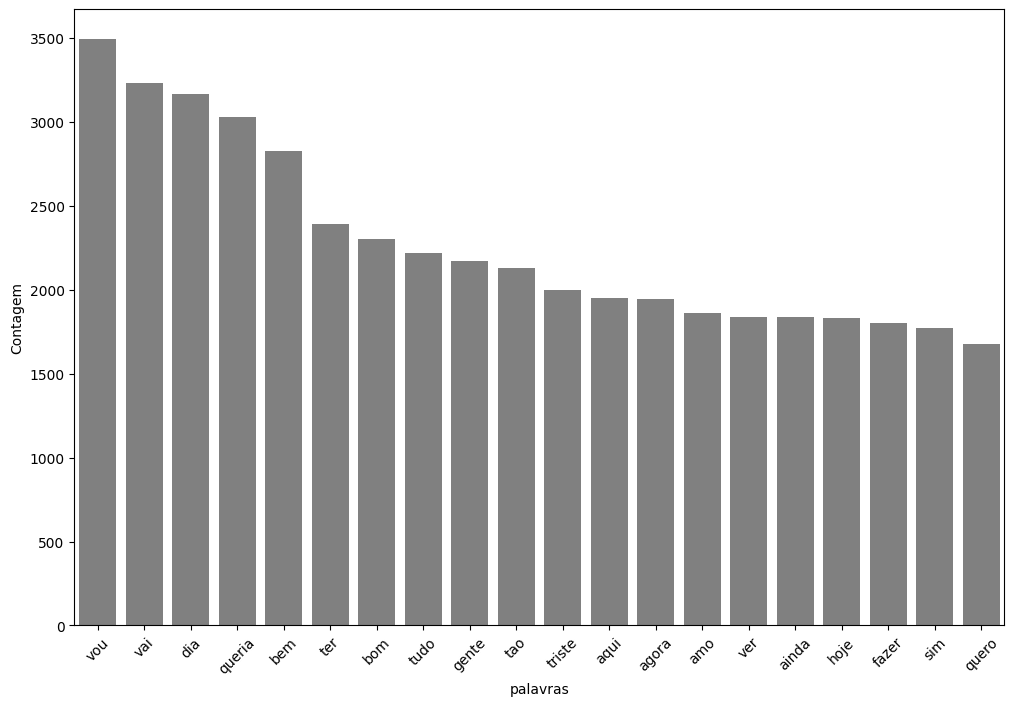

In [143]:
pareto(sentimentos,"tratamento_4", 20)

In [144]:
# Aplica stemming ao texto para tratamento 5
stemmer = nltk.RSLPStemmer()
frase_processada = list()
for opiniao in sentimentos["tratamento_4"]:
    nova_frase = list()
    opiniao = opiniao.lower()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra.lower() not in stopwords_sem_acento_filtradas:
          if palavra.lower() not in stopwords_sem_acento and len(palavra) > 1:
            nova_frase.append(stemmer.stem(palavra))
    frase_processada.append(' '.join(nova_frase))

sentimentos["tratamento_5"] = frase_processada
acuracia_tratamento5 = classificar_texto(sentimentos, "tratamento_5", "classificacao")

In [145]:
# Aplica TF-IDF com e sem n-grams
tfidf = TfidfVectorizer(lowercase=False, max_features=50)

caracteristicas = tfidf.fit_transform(sentimentos['tweet_text'])

caracteristicas_df = pd.DataFrame(
    caracteristicas.todense(),
    columns=tfidf.get_feature_names_out()
)

print(caracteristicas_df.head())

         Eu   as  bem        co       com  como   da        de  dia        do  \
0  0.000000  0.0  0.0  0.000000  0.000000   0.0  0.0  0.000000  0.0  0.000000   
1  0.000000  0.0  0.0  0.000000  0.000000   0.0  0.0  0.000000  0.0  0.000000   
2  0.000000  0.0  0.0  0.220665  0.000000   0.0  0.0  0.000000  0.0  0.546283   
3  0.000000  0.0  0.0  0.376323  0.000000   0.0  0.0  0.346671  0.0  0.000000   
4  0.284368  0.0  0.0  0.186390  0.227719   0.0  0.0  0.000000  0.0  0.230716   

   ...       ter        to  tudo   tá        um       uma       vai        vc  \
0  ...  0.000000  0.000000   0.0  0.0  0.000000  0.000000  0.000000  0.000000   
1  ...  0.000000  0.000000   0.0  0.0  0.000000  0.000000  0.000000  0.000000   
2  ...  0.000000  0.000000   0.0  0.0  0.550867  0.300324  0.000000  0.000000   
3  ...  0.000000  0.587197   0.0  0.0  0.000000  0.000000  0.000000  0.000000   
4  ...  0.302305  0.000000   0.0  0.0  0.000000  0.000000  0.290116  0.306379   

   você  vou  
0   0.0  0.

In [146]:
tfidf_bruto = tfidf.fit_transform(sentimentos['tweet_text'])
treino, teste, classe_treino, classe_teste = train_test_split(tfidf_bruto,
                                                              sentimentos["classificacao"],
                                                              random_state = 42)

regressao_logistica = LogisticRegression()
regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf_bruto = regressao_logistica.score(teste, classe_teste)
print(acuracia_tfidf_bruto)


0.6183476330473391


In [147]:
tfidf_tratados = tfidf.fit_transform(sentimentos['tratamento_5'])
treino, teste, classe_treino, classe_teste = train_test_split(tfidf_tratados,
                                                              sentimentos["classificacao"],
                                                              random_state = 42)

regressao_logistica = LogisticRegression()
regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf_tratados = regressao_logistica.score(teste, classe_teste)
print(acuracia_tfidf_tratados)


0.6111477770444591


In [148]:
tfidf = TfidfVectorizer(lowercase=False, ngram_range=(1,2))
vetor_tfidf = tfidf.fit_transform(sentimentos["tratamento_5"])
treino, teste, classe_treino, classe_teste = train_test_split(vetor_tfidf, sentimentos['classificacao'],
                                                              random_state = 42)

regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf_ngrams = regressao_logistica.score(teste, classe_teste)
print(acuracia_tfidf_ngrams)


0.750764984700306


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [149]:
# Exibe os pesos das palavras mais importantes para a classificação positiva e negativa
pesos = pd.DataFrame(
    regressao_logistica.coef_[0].T,
    index = tfidf.get_feature_names_out()

)

pesos.nlargest(10,0)
pesos.nsmallest(10,0)

,0
trist,-11.647038
quer,-8.639003
saudad,-8.151690
infeliz,-7.708582
bar,-7.579206
pox,-7.112437
sdd,-5.788286
gt,-5.597078
amo,-5.362457
tao,-4.638996


In [150]:
def prever_emocao(frase, modelo, vetorizer):
    # Realize o pré-processamento necessário na frase
    frase_processada = [unidecode.unidecode(frase)]

    # Use o mesmo vetorizer que você usou para treinar o modelo
    frase_vetorizada = vetorizer.transform(frase_processada)

    # Faça a previsão usando o modelo treinado
    previsao = modelo.predict(frase_vetorizada)

    return previsao[0]

# Exemplo de uso
modelo = regressao_logistica  # Use o modelo que você treinou
vetorizer = tfidf  # Use o vetorizer que você usou para treinar o modelo

frase = "estou triste"
emocao = prever_emocao(frase, modelo, vetorizer)
print(f"A emoção da frase '{frase}' é: {emocao}")

frase = "estou  feliz"
emocao = prever_emocao(frase, modelo, vetorizer)
print(f"A emoção da frase '{frase}' é: {emocao}")


A emoção da frase 'estou triste' é: 0
A emoção da frase 'estou  feliz' é: 1
